In [13]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import rqa_functions as rqa
from misc_utils import transform_tuples_to_symbols

In [6]:
def load_pickle_file(filename):
    """
    Load a pickle file.

    Parameters:
    - filename (str): The path to the pickle file to be loaded.

    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(filename, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except EOFError:
        print(f"Error: The file '{filename}' may be corrupted or empty.")
    except pickle.UnpicklingError:
        print(f"Error: The file '{filename}' could not be unpickled. It may not be a valid pickle file or may be corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
session_clusterings = load_pickle_file('./clustering_data.pkl')

In [7]:
session_data = list(session_clusterings.keys())

In [8]:
data = []
recurrence_plots = {}

for session_code in session_data:
    metadata = session_clusterings[session_code]['metadata']
    sub1_seq,sub2_seq = session_clusterings[session_code]['clustering']
    joint_seq = list(zip(sub1_seq,sub2_seq))
    joint_seq = transform_tuples_to_symbols(joint_seq)

    start_list = list(metadata['start'])
    stop_list = list(metadata['stop'])
    start_stop = list(zip(start_list,stop_list))
    conditions = list(metadata['condition'])
    session_type = metadata['session_type'][0]

    recurrence_matrix = rqa.build_rp(joint_seq)
    recurrence_plots[session_code] = {'rp': recurrence_matrix,
                                      'symbol_sequence': joint_seq}
    for j,indices in enumerate(start_stop):
        condition = conditions[j]
        if condition == '1_lead' or condition == '2_lead':
            condition = 'Leader-Follower'
        start, stop = indices
        
        matrix = recurrence_matrix[start:stop,start:stop]

        vlines = rqa.find_lines(matrix, min_len=2, direction='vertical')
        vmean = np.mean(vlines)
        vvar = np.var(vlines)
        dlines = rqa.find_lines(matrix, min_len=2, direction='diagonal')
        dmean = np.mean(dlines)
        dvar = np.var(dlines)

        df_row = {'Session': session_code,
                'Session Type': session_type,
                'Condition': condition,
                'Average Dwell Time': vmean,
                'Average Motif Length': dmean}
        data.append(df_row)

data_df = pd.DataFrame(data)
data_df

Session     Session Type        Condition  Average Dwell Time  \
0    20221003  Synchronization        Uncoupled            2.877586   
1    20221003  Synchronization  Leader-Follower            2.749616   
2    20221003  Synchronization           Mutual            2.422680   
3    20221003  Synchronization  Leader-Follower            3.294586   
4    20221003  Synchronization  Leader-Follower            2.199438   
..        ...              ...              ...                 ...   
139  20220804  Synchronization  Leader-Follower            4.000000   
140  20220804  Synchronization        Uncoupled            2.769585   
141  20220804  Synchronization  Leader-Follower            3.403207   
142  20220804  Synchronization  Leader-Follower            2.629888   
143  20220804  Synchronization           Mutual            3.745042   

     Average Motif Length  
0                5.360656  
1                6.355140  
2                3.109375  
3                5.825175  
4                2.088889  
..                    ...  
139             11.746193  
140              3.606897  
141              8.995098  
142              6.666667  
143             12.230769  

[144 rows x 5 columns]

60


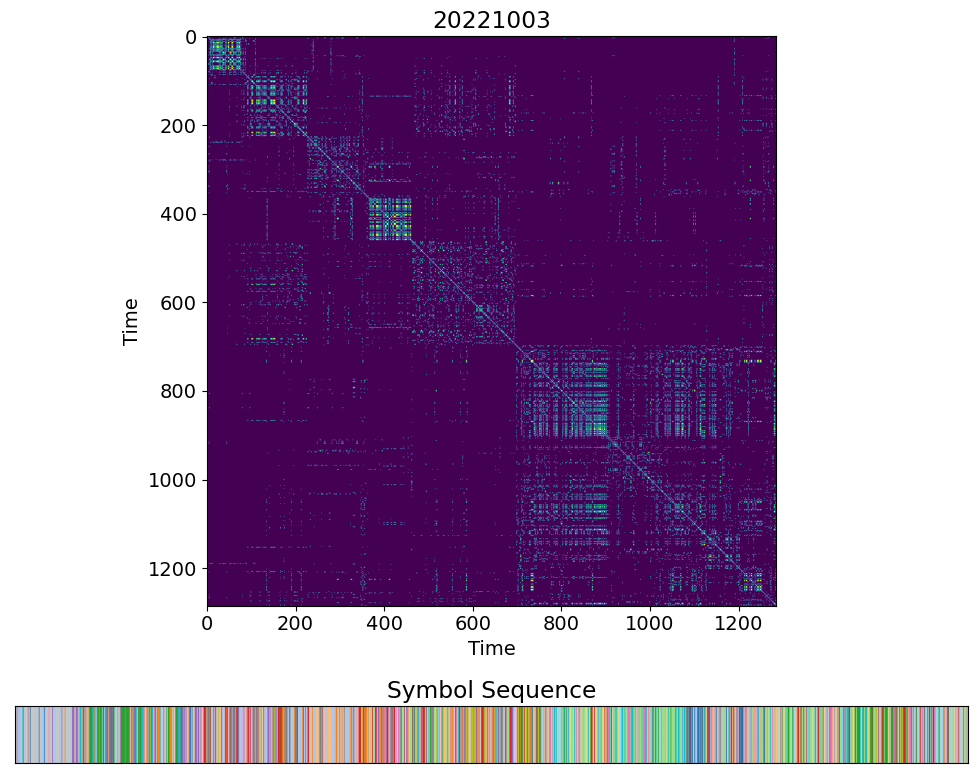

72


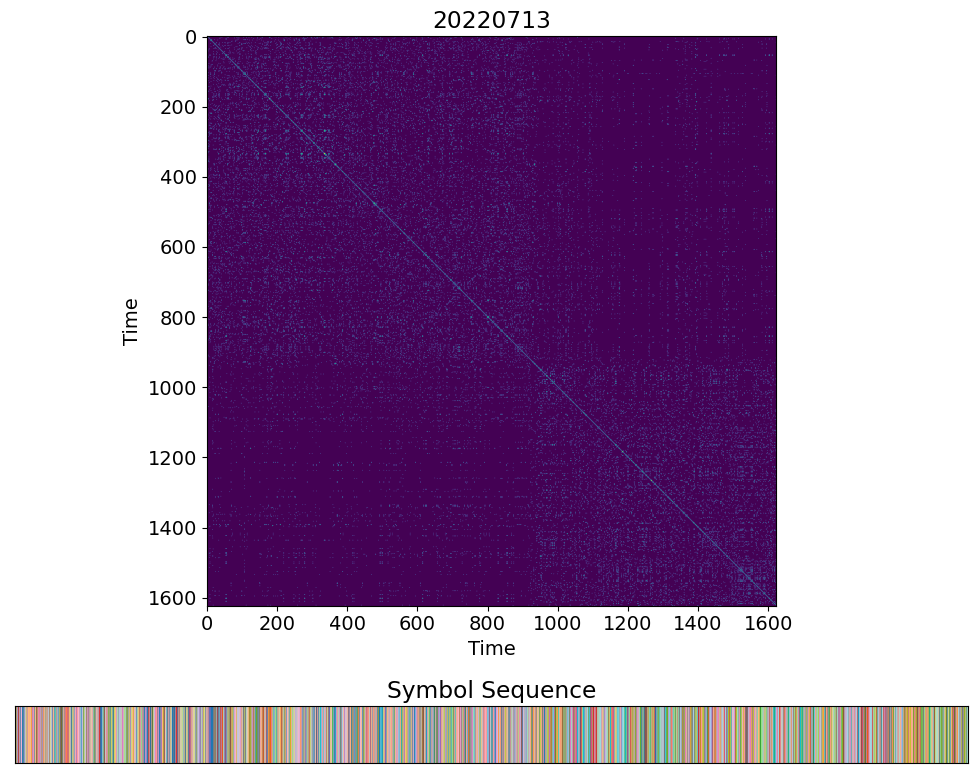

40


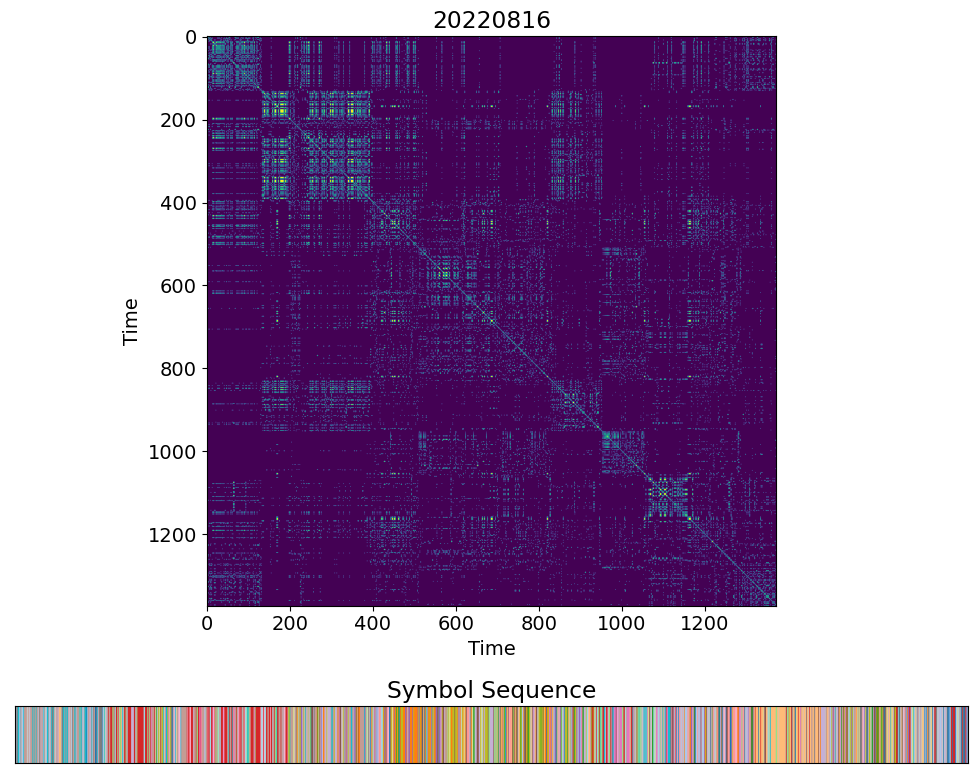

72


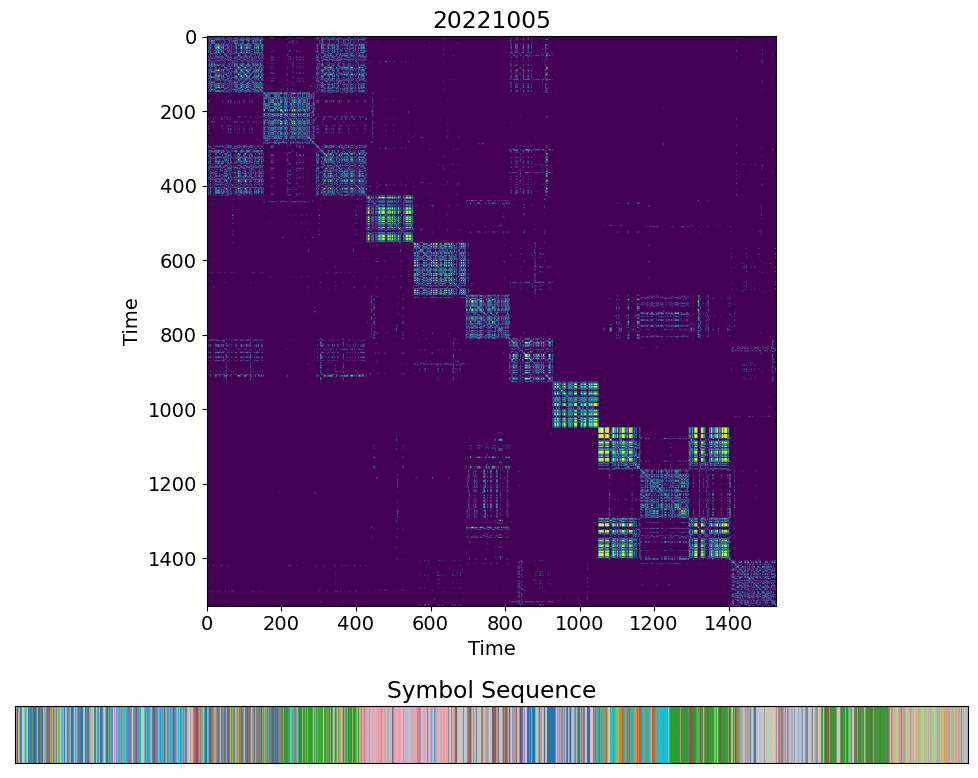

40


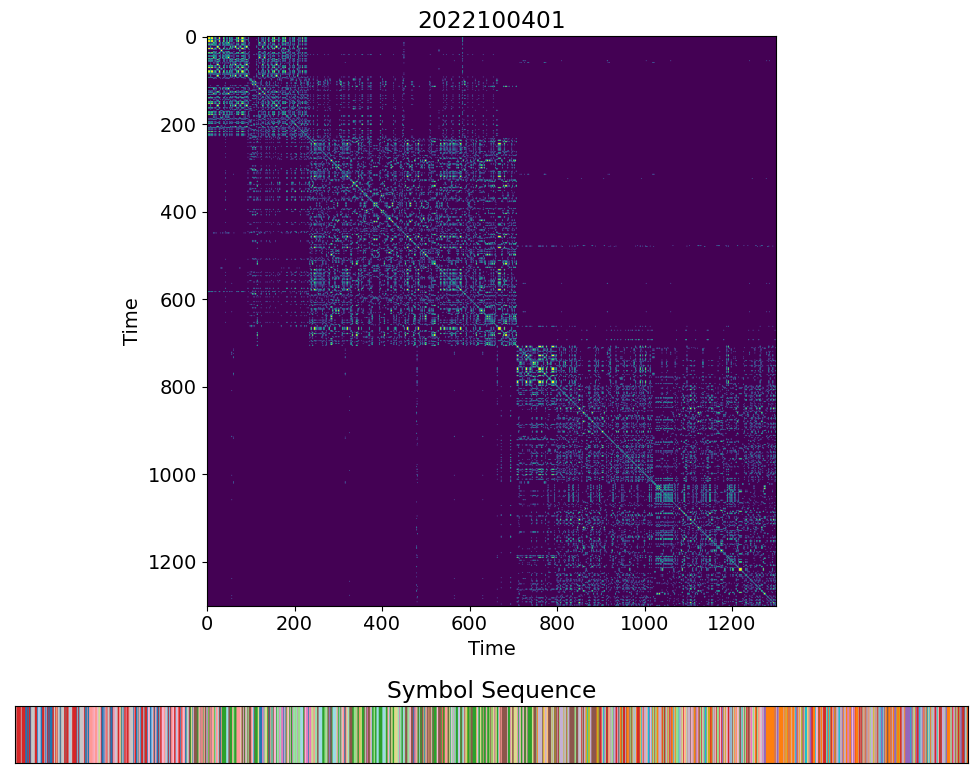

74


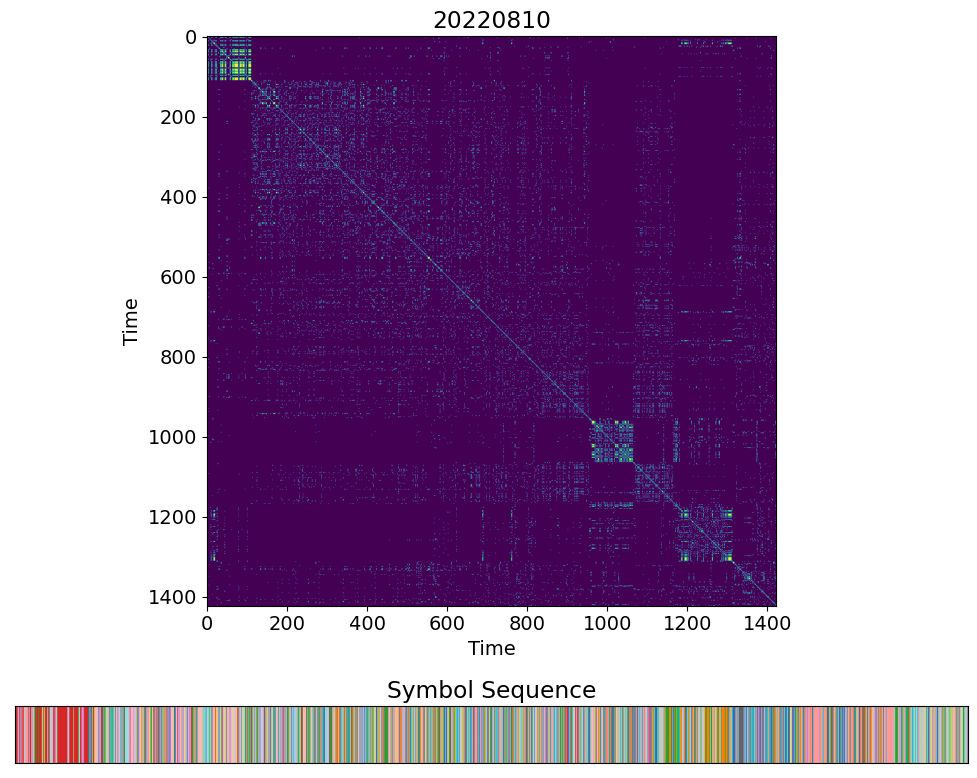

60


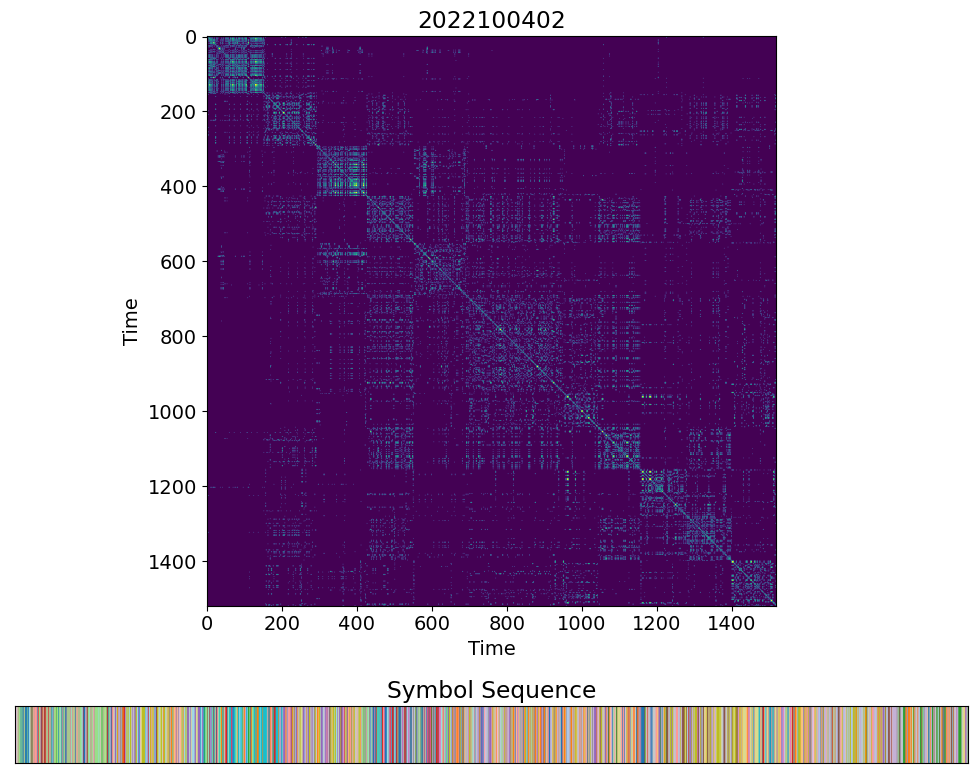

72


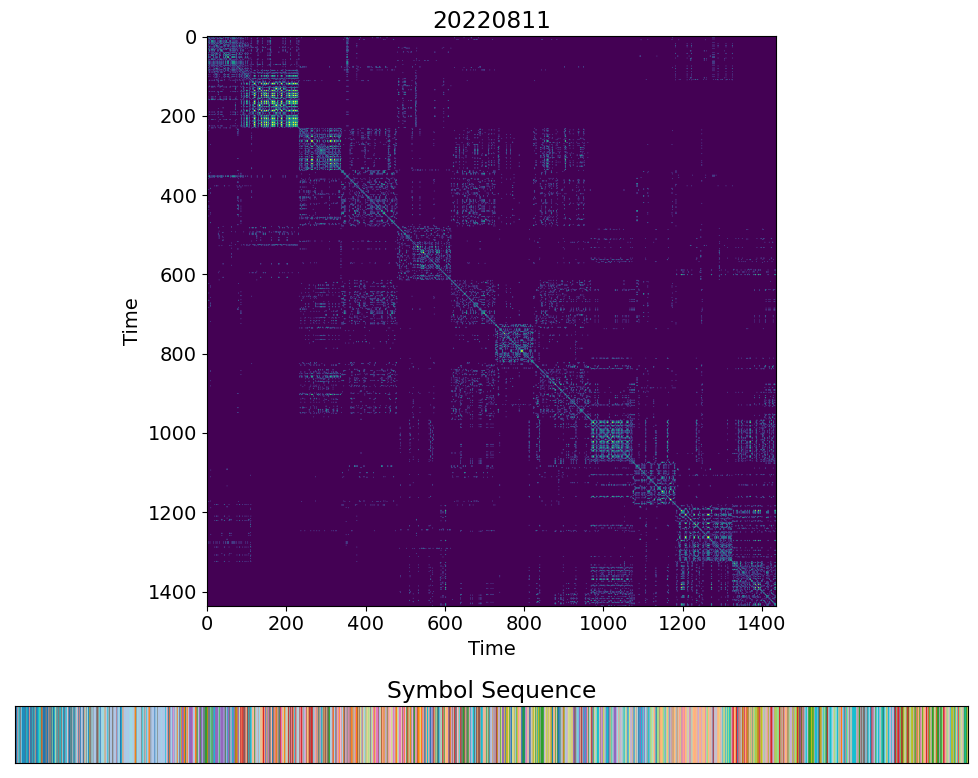

48


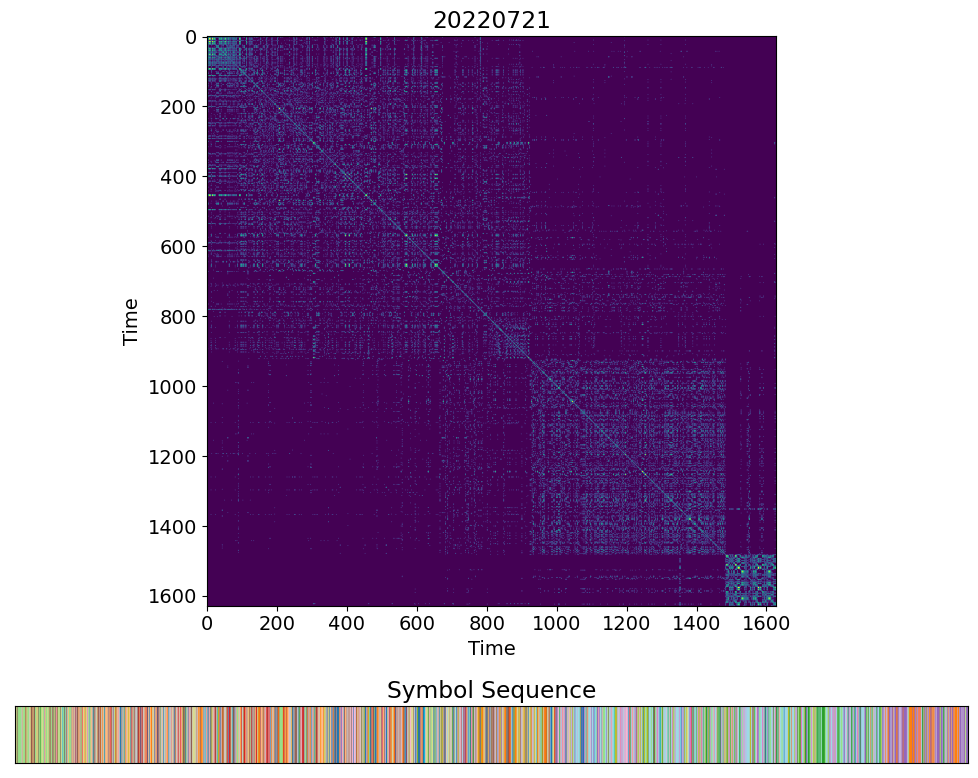

64


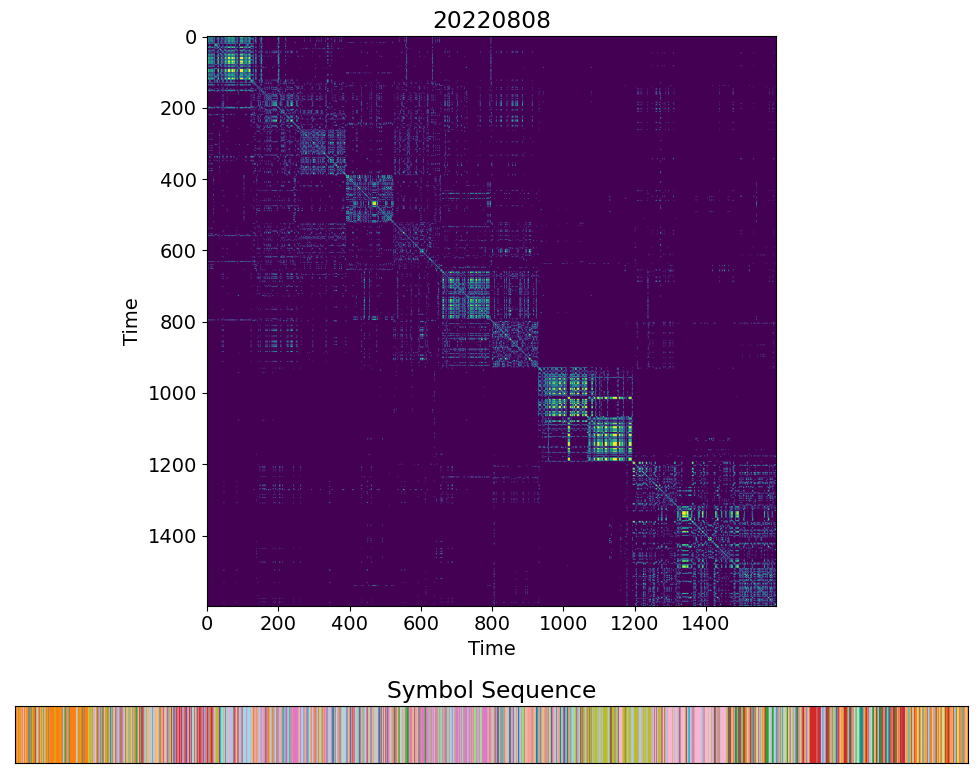

42


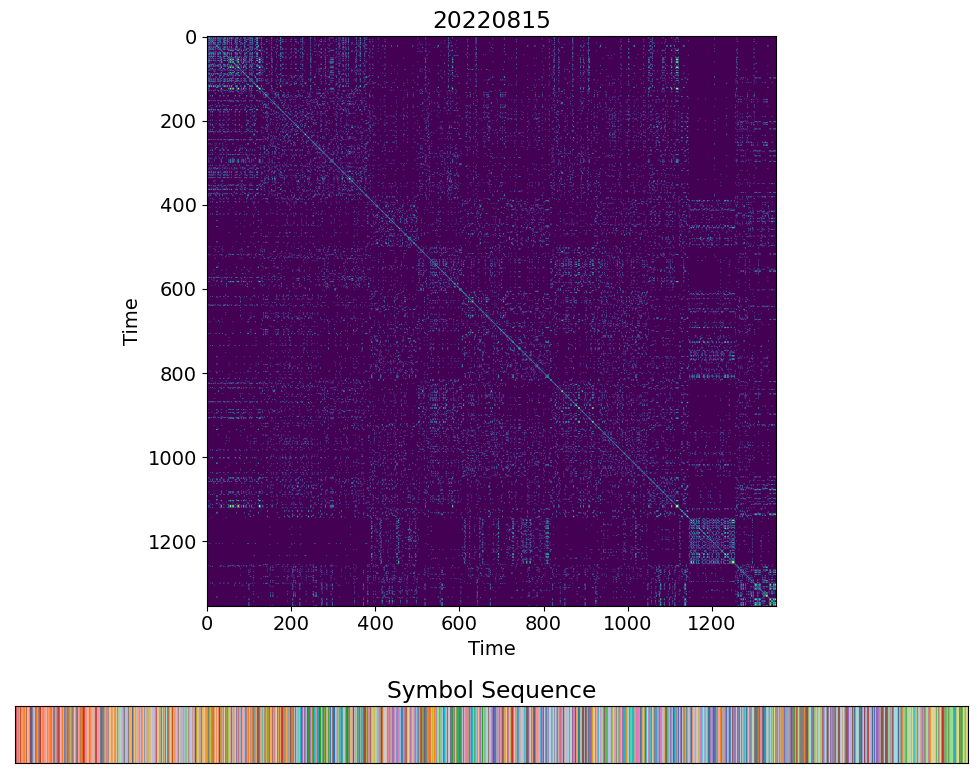

75


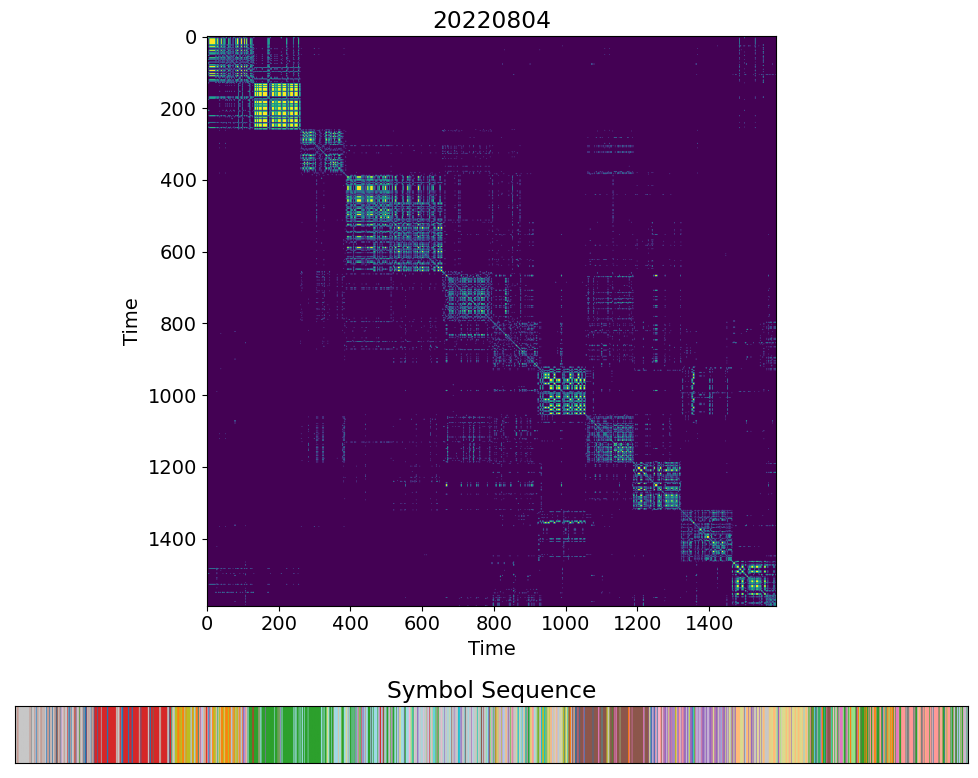

In [14]:
for session_code in recurrence_plots:
    recurrence_matrix = recurrence_plots[session_code]['rp']
    joint_seq = recurrence_plots[session_code]['symbol_sequence']

    # Step 1: Create a color map
    unique_symbols = np.unique(joint_seq)
    print(len(unique_symbols))
    # Create a colormap that maps each symbol to a color
    symbol_to_color = plt.cm.get_cmap('tab20', len(unique_symbols))
    symbol_colors = {symbol: symbol_to_color(i) for i, symbol in enumerate(unique_symbols)}

    # Initialize the figure with GridSpec
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[10, 1])

    # Step 2: Plot the Recurrence Matrix in a subplot
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(recurrence_matrix)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Time')
    ax1.set_title(session_code)
    ax1.axis('on')

    # Step 3: Generate the Symbol Colorbar in another subplot
    # Create an array where each position corresponds to the color of the symbol at that position in the sequence
    symbol_sequence_colors = np.array([symbol_colors[symbol] for symbol in joint_seq]).reshape(1, len(joint_seq), 4)
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(symbol_sequence_colors, aspect='auto')
    ax2.set_title("Symbol Sequence")
    ax2.set_yticks([])
    ax2.set_xticks([])

    plt.tight_layout()
    plt.show()

In [9]:
columns_to_normalize = ['Average Dwell Time', 'Average Motif Length']

# Apply the custom transformation
for col in columns_to_normalize:
    data_df[col + ' Normalized'] = data_df.groupby(['Session'])[col].transform(lambda x: np.log2(x / x.mean()))

/tmp/ipykernel_1097514/2853581497.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['Session'] = aux_df['Session'].map(session_mapping)


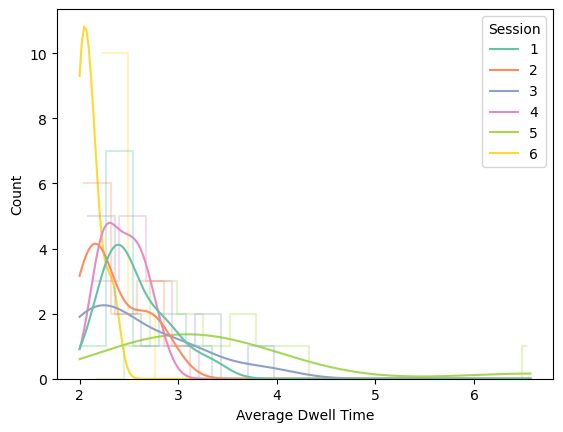

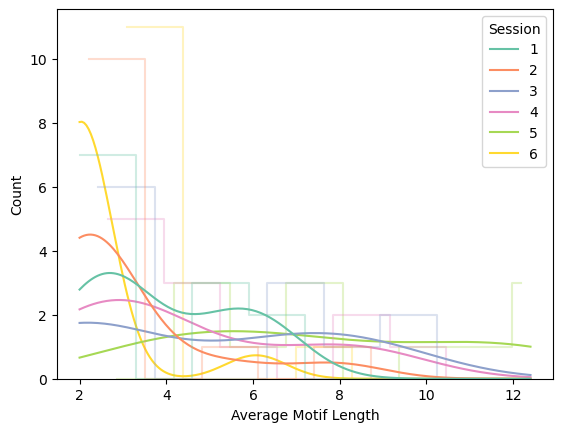

/tmp/ipykernel_1097514/2853581497.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['Session'] = aux_df['Session'].map(session_mapping)


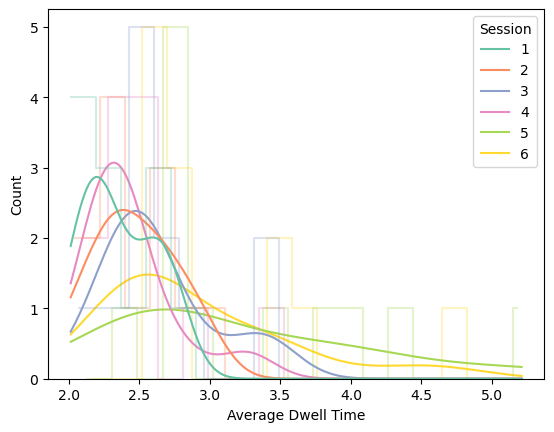

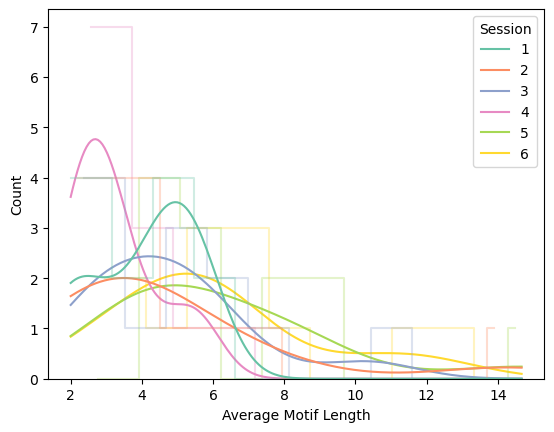

In [10]:
aux_df = data_df[data_df['Session Type'] == 'Synchronization']

session_list = list(set(aux_df['Session']))
session_mapping = {}
for i,session in enumerate(session_list):
    session_mapping[session] = i+1
session_mapping
aux_df['Session'] = aux_df['Session'].map(session_mapping)
metric_list = ['Average Dwell Time','Average Motif Length']

for metric in metric_list:
    sns.histplot(aux_df, x=metric,hue='Session',multiple='dodge',kde=True,palette='Set2', element='step', fill=False, alpha=0.3)

    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_alpha(1)  # Set the legend markers to fully opaque
        
    plt.show()

aux_df = data_df[data_df['Session Type'] == 'Syncopation']

session_list = list(set(aux_df['Session']))
session_mapping = {}
for i,session in enumerate(session_list):
    session_mapping[session] = i+1
session_mapping
aux_df['Session'] = aux_df['Session'].map(session_mapping)
metric_list = ['Average Dwell Time','Average Motif Length']

for metric in metric_list:
    sns.histplot(aux_df, x=metric,hue='Session',multiple='dodge',kde=True,palette='Set2', element='step', fill=False, alpha=0.3)

    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_alpha(1)  # Set the legend markers to fully opaque
        
    plt.show()

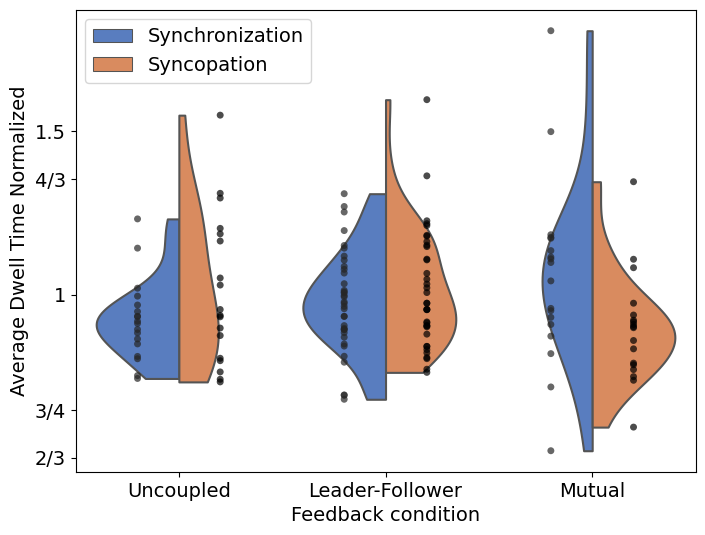

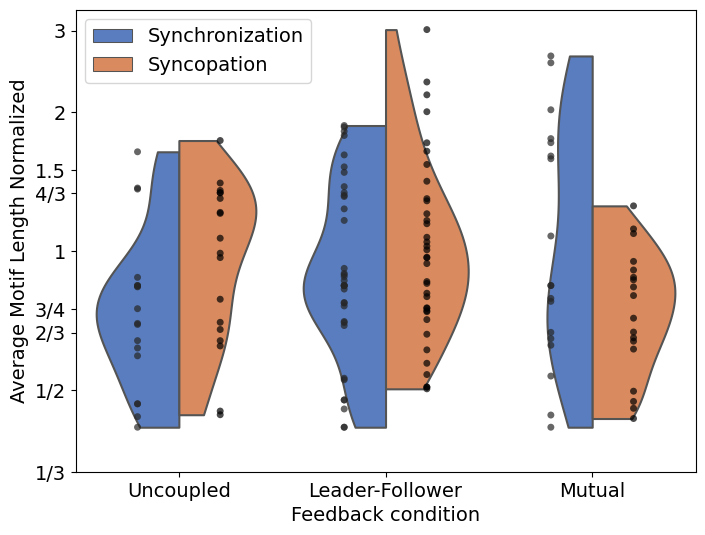

In [11]:
# Set global font size for all elements
plt.rcParams.update({'font.size': 14})

metric_list = ['Average Dwell Time Normalized','Average Motif Length Normalized']

# Define the tick values and labels
log2_tick_values = np.log2([3, 2, 1.5, 4/3, 1, 3/4, 2/3, 1/2, 1/3])
tick_labels = ['3', '2', '1.5', '4/3', '1', '3/4', '2/3', '1/2', '1/3']

log2_tick_values2 = np.log2([1.5, 4/3, 1, 3/4, 2/3])
tick_labels2 = ['1.5', '4/3', '1', '3/4', '2/3']

for metric in metric_list:
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    condition_order = ['Uncoupled', 'Leader-Follower', 'Mutual']

    # Create the violin plot
    sns.violinplot(x='Condition', y=metric, hue='Session Type', data=data_df, split=True, inner=None, order=condition_order, palette='muted', cut=0, ax=ax)
    sns.stripplot(x='Condition', y=metric, hue='Session Type', data=data_df, dodge=True, color='black', edgecolor='black', size=5, alpha=0.7, jitter=False, ax=ax)

    # Add titles and labels as needed
    ax.set_xlabel('Feedback condition')
    ax.set_ylabel(metric)

    # Set y-axis tick locations and labels
    if metric == 'Average Dwell Time Normalized':
        ax.set_yticks(log2_tick_values2)
        ax.set_yticklabels(tick_labels2)
    else:
        ax.set_yticks(log2_tick_values)
        ax.set_yticklabels(tick_labels)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:2], labels[0:2], loc='upper left')

    # Display the plot
    plt.show()
